## Migrating from Spark to BigQuery via Dataproc -- Part 5

* [Part 1](01_spark.ipynb): The original Spark code, now running on Dataproc (lift-and-shift).
* [Part 2](02_gcs.ipynb): Replace HDFS by Google Cloud Storage. This enables job-specific-clusters. (cloud-native)
* [Part 3](03_automate.ipynb): Automate everything, so that we can run in a job-specific cluster. (cloud-optimized)
* [Part 4](04_bigquery.ipynb): Load CSV into BigQuery, use BigQuery. (modernize)
* [Part 5](05_functions.ipynb): Using Cloud Functions, launch analysis every time there is a new file in the bucket. (serverless)


### Catch-up cell

In [1]:
%%bash
bq mk sparktobq
wget https://storage.googleapis.com/cloud-training/dataengineering/lab_assets/sparklab/kddcup.data_10_percent.gz
gunzip kddcup.data_10_percent.gz
export BUCKET=$(gcloud info --format='value(config.project)')
gcloud storage buckets create gs://$BUCKET
gcloud storage cp kdd* gs://$BUCKET/

BigQuery error in mk operation: Dataset 'qwiklabs-gcp-01-6fbceeed41a4:sparktobq'
already exists.


--2026-01-18 08:18:54--  https://storage.googleapis.com/cloud-training/dataengineering/lab_assets/sparklab/kddcup.data_10_percent.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 172.253.118.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2144903 (2.0M) [application/x-gzip]
Saving to: ‘kddcup.data_10_percent.gz’

     0K .......... .......... .......... .......... ..........  2%  247K 8s
    50K .......... .......... .......... .......... ..........  4%  253K 8s
   100K .......... .......... .......... .......... ..........  7%  736K 6s
   150K .......... .......... .......... .......... ..........  9%  555K 5s
   200K .......... .......... .......... .......... .......... 11%  782K 5s
   250K .......... .......... .......... .......... .......... 14%  989K 4s
   300K .......... .......... .......... .......... .......... 16% 1.31M 

### Create reporting function

In [2]:
%%writefile main.py

from google.cloud import bigquery
import google.cloud.storage as gcs
import tempfile
import os

def create_report(BUCKET, gcsfilename, tmpdir):
    """
    Creates report in gs://BUCKET/ based on contents in gcsfilename (gs://bucket/some/dir/filename)
    """
    # connect to BigQuery
    client = bigquery.Client()
    destination_table = 'sparktobq.kdd_cup'
    
    # Specify table schema. Autodetect is not a good idea for production code
    job_config = bigquery.LoadJobConfig()
    schema = [
        bigquery.SchemaField("duration", "INT64"),
    ]
    for name in ['protocol_type', 'service', 'flag']:
        schema.append(bigquery.SchemaField(name, "STRING"))
    for name in 'src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins'.split(','):
        schema.append(bigquery.SchemaField(name, "INT64"))
    schema.append(bigquery.SchemaField("unused_10", "STRING"))
    schema.append(bigquery.SchemaField("num_compromised", "INT64"))
    schema.append(bigquery.SchemaField("unused_12", "STRING"))
    for name in 'su_attempted,num_root,num_file_creations'.split(','):
        schema.append(bigquery.SchemaField(name, "INT64")) 
    for fieldno in range(16, 41):
        schema.append(bigquery.SchemaField("unused_{}".format(fieldno), "STRING"))
    schema.append(bigquery.SchemaField("label", "STRING"))
    job_config.schema = schema

    # Load CSV data into BigQuery, replacing any rows that were there before
    job_config.create_disposition = bigquery.CreateDisposition.CREATE_IF_NEEDED
    job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE
    job_config.skip_leading_rows = 0
    job_config.source_format = bigquery.SourceFormat.CSV
    load_job = client.load_table_from_uri(gcsfilename, destination_table, job_config=job_config)
    print("Starting LOAD job {} for {}".format(load_job.job_id, gcsfilename))
    load_job.result()  # Waits for table load to complete.
    print("Finished LOAD job {}".format(load_job.job_id))
    
    # connections by protocol
    sql = """
        SELECT COUNT(*) AS count
        FROM sparktobq.kdd_cup
        GROUP BY protocol_type
        ORDER by count ASC    
    """
    connections_by_protocol = client.query(sql).to_dataframe()
    connections_by_protocol.to_csv(os.path.join(tmpdir,"connections_by_protocol.csv"))
    print("Finished analyzing connections")
    
    # attacks plot
    sql = """
                            SELECT 
                             protocol_type, 
                             CASE label
                               WHEN 'normal.' THEN 'no attack'
                               ELSE 'attack'
                             END AS state,
                             COUNT(*) as total_freq,
                             ROUND(AVG(src_bytes), 2) as mean_src_bytes,
                             ROUND(AVG(dst_bytes), 2) as mean_dst_bytes,
                             ROUND(AVG(duration), 2) as mean_duration,
                             SUM(num_failed_logins) as total_failed_logins,
                             SUM(num_compromised) as total_compromised,
                             SUM(num_file_creations) as total_file_creations,
                             SUM(su_attempted) as total_root_attempts,
                             SUM(num_root) as total_root_acceses
                           FROM sparktobq.kdd_cup
                           GROUP BY protocol_type, state
                           ORDER BY 3 DESC
    """
    attack_stats = client.query(sql).to_dataframe()
    ax = attack_stats.plot.bar(x='protocol_type', subplots=True, figsize=(10,25))
    ax[0].get_figure().savefig(os.path.join(tmpdir,'report.png'));
    print("Finished analyzing attacks")
    
    bucket = gcs.Client().get_bucket(BUCKET)
    for blob in bucket.list_blobs(prefix='sparktobq/'):
        blob.delete()
    for fname in ['report.png', 'connections_by_protocol.csv']:
        bucket.blob('sparktobq/{}'.format(fname)).upload_from_filename(os.path.join(tmpdir,fname))
    print("Uploaded report based on {} to {}".format(gcsfilename, BUCKET))


def bigquery_analysis_cf(data, context):
    # check that trigger is for a file of interest
    bucket = data['bucket']
    name = data['name']
    if ('kddcup' in name) and not ('gz' in name):
        filename = 'gs://{}/{}'.format(bucket, data['name'])
        print(bucket, filename)
        with tempfile.TemporaryDirectory() as tmpdir:
            create_report(bucket, filename, tmpdir)

Overwriting main.py


In [3]:
%%writefile requirements.txt
google-cloud-bigquery
google-cloud-storage
pandas
matplotlib

Writing requirements.txt


In [4]:
# verify that the code in the CF works
name='kddcup.data_10_percent'
if 'kddcup' in name and not ('gz' in name):
    print(True)

True


## Test that the function endpoint works

Starting LOAD job 1f2321bb-dd74-4f01-8e03-e752c0e9c47d for gs://qwiklabs-gcp-01-6fbceeed41a4/kddcup.data_10_percent
Finished LOAD job 1f2321bb-dd74-4f01-8e03-e752c0e9c47d
Finished analyzing connections
Finished analyzing attacks
Uploaded report based on gs://qwiklabs-gcp-01-6fbceeed41a4/kddcup.data_10_percent to qwiklabs-gcp-01-6fbceeed41a4


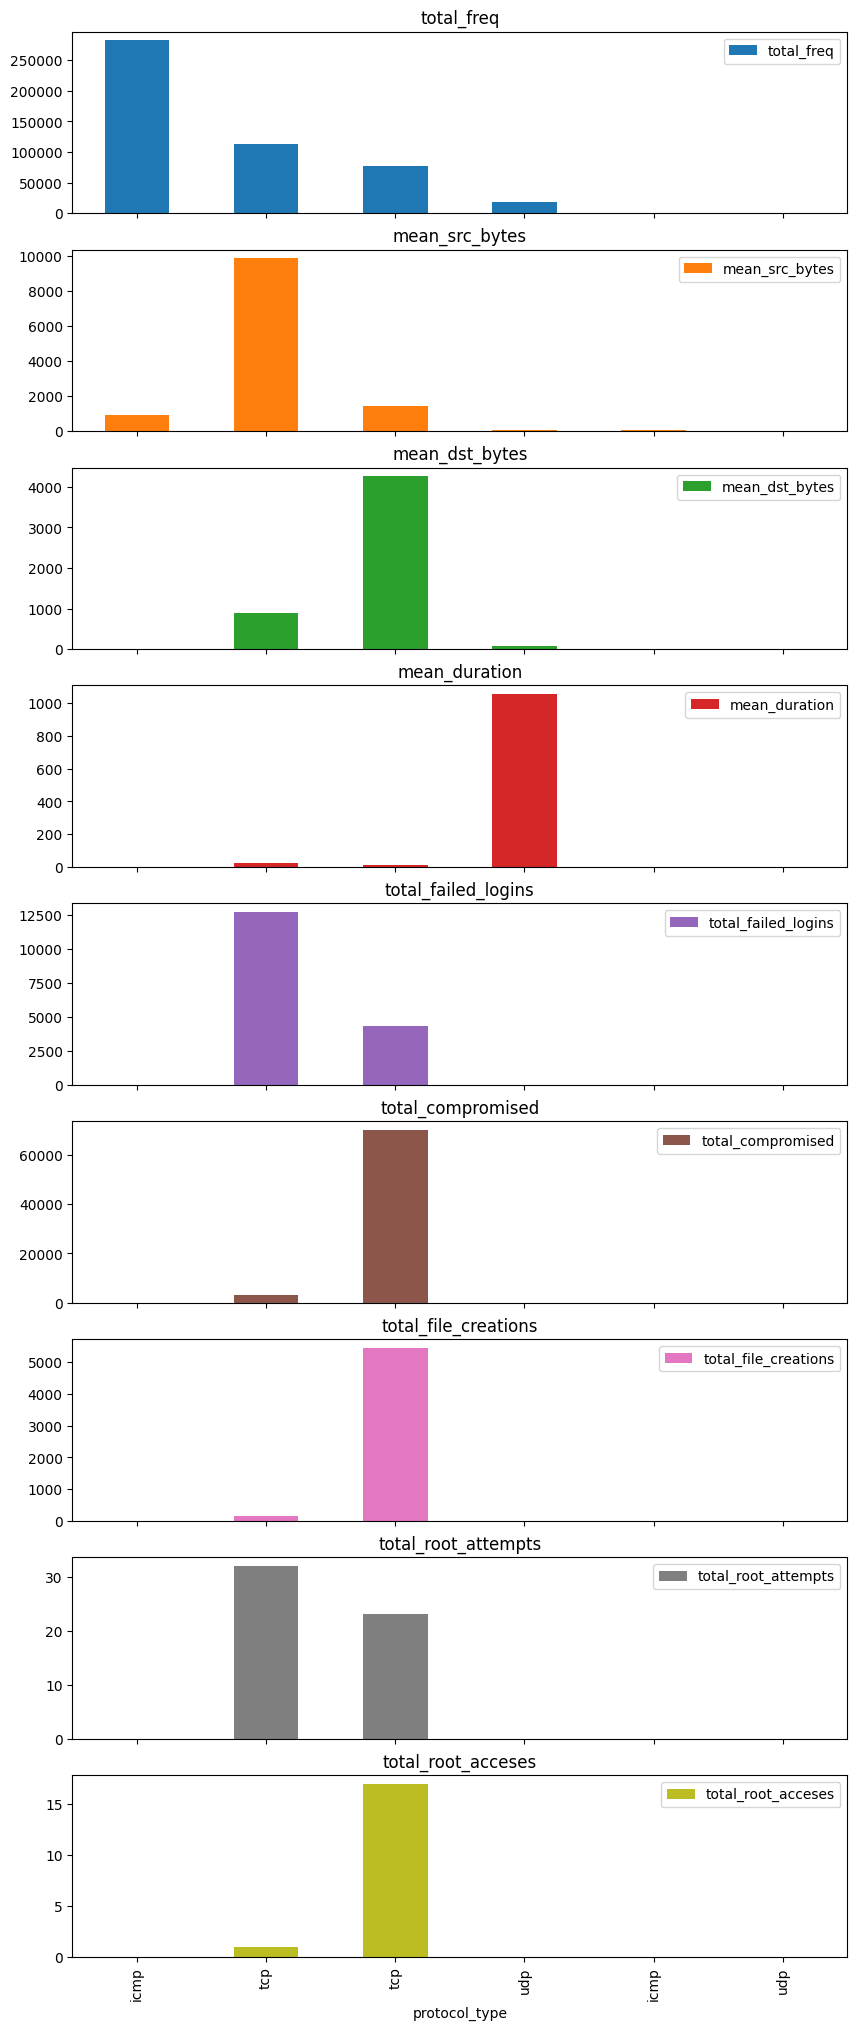

In [5]:
# test that the function works
import main as bq

BUCKET='qwiklabs-gcp-01-6fbceeed41a4' # CHANGE
try:
    bq.create_report(BUCKET, 'gs://{}/kddcup.data_10_percent'.format(BUCKET), "/tmp")
except Exception as e:
    print(e.errors)

## Deploy the cloud function

In [10]:
!gcloud functions deploy bigquery_analysis_cf --no-gen2 --region asia-southeast1 --runtime python310 --trigger-resource $BUCKET --trigger-event google.storage.object.finalize

Deploying function (may take a while - up to 2 minutes)...⠶                    
For Cloud Build Logs, visit: https://console.cloud.google.com/cloud-build/builds;region=asia-southeast1/be740720-ba1e-44ab-b2cd-a35958d560f5?project=777524476422
Deploying function (may take a while - up to 2 minutes)...done.                
automaticUpdatePolicy: {}
availableMemoryMb: 256
buildId: be740720-ba1e-44ab-b2cd-a35958d560f5
buildName: projects/777524476422/locations/asia-southeast1/builds/be740720-ba1e-44ab-b2cd-a35958d560f5
buildServiceAccount: projects/qwiklabs-gcp-01-6fbceeed41a4/serviceAccounts/777524476422-compute@developer.gserviceaccount.com
dockerRegistry: ARTIFACT_REGISTRY
entryPoint: bigquery_analysis_cf
eventTrigger:
  eventType: google.storage.object.finalize
  failurePolicy: {}
  resource: projects/_/buckets/qwiklabs-gcp-01-6fbceeed41a4
  service: storage.googleapis.com
ingressSettings: ALLOW_ALL
labels:
  deployment-tool: cli-gcloud
maxInstances: 5
name: projects/qwiklabs-gcp-01-6fb

## Try it out

Copy the file to the bucket:

In [7]:
!gcloud storage cp kddcup.data_10_percent gs://$BUCKET/

Copying file://kddcup.data_10_percent to gs://qwiklabs-gcp-01-6fbceeed41a4/kddcup.data_10_percent
  Completed files 1/1 | 71.4MiB/71.4MiB                                        

Average throughput: 25.9MiB/s


Verify that the Cloud Function is being run. You can do this from the [Cloud Functions](https://console.cloud.google.com/functions/) part of the GCP Console.

Once the function is complete (in about 30 seconds), see if the output folder contains the report:

In [8]:
!gcloud storage ls gs://$BUCKET/sparktobq

gs://qwiklabs-gcp-01-6fbceeed41a4/sparktobq/connections_by_protocol.csv
gs://qwiklabs-gcp-01-6fbceeed41a4/sparktobq/report.png


Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.